# 0. Introduction to fitting spectral data
These tutorial notebooks will give a basic introduction to peak fitting of XRD scattering spectra using the the xrdfit package.

Some example spectra can be found in the `example_data` folder in the root folder of the `xrd_fit` package and will be used here to demonstrate the various functions of the scripts. To use these notebooks you should proceed in order, executing each cell at a time since some cells depend on variables defined in previous cells.

## 0.1 Required packages

If you installed `xrdfit` using pip all of these packages should be installed already.

`xrdfit` uses the `lmfit` package to do the fitting: https://lmfit.github.io/. It also uses `Pandas` for loading data, `Numpy` for data processing, `matplotlib` for plotting, `dill` for saving fits to disk and `tqdm` for progress bars.

## 0.2. Data format

These scripts read data from tab separated text files. The format of the file is the standard format output by DAWN (https://dawnsci.org/about/). DAWN is a data analysis and processing program commonly used for processing synchrotron data. 

The data file does not have any column headings or title line. The first column of the data file is the two theta diffraction angle. Each subsequent column corresponds to a cake of data from the diffraction pattern.

In this analysis we specify that an XRD experiment produces a circular **diffraction pattern**
$$I = f(\chi, 2\theta)$$
where $I$ is beam intensity, $\chi$ is the azimuthal angle and $2\theta$ is the scattering angle. The intensity is measured at a discreet number of azimuthal angles which results in the pattern being made up of a number of sectors which we call **cakes** (since the sectors look like a slice of cake).

<img src="images/cake_numbering.svg" alt="Illustration of cake numbering" title="Illustration of cake numbering" width="300" />
    
By convention the **cakes** in the input data files are ordered clockwise but no information is provided about the location of the first cake. This means the angle of the first cake must be provided as part of the analysis.


## 0.3. Peak model fit

The model fit used in `xrdfit` is the Pseudo-Voigt (PV) model. This is a combination of a Gaussian and Lorentzian distribution function which is commonly used for the fitting of spectroscopic peaks since it is reliably robust to peak broadening. `xrdfit` uses the PV model from `lmfit` (https://lmfit.github.io/lmfit-py/builtin_models.html#pseudovoigtmodel). The model parameters are as follows:

* sigma $(\sigma)$ - This controls the width of the fitted peak
* fraction $(\alpha)$ - The ratio of the Gaussian and Lorentzian components. 
* center $(\mu)$ - The center of the fitted peak
* amplitude ($A$) - The amplitude of the Gaussian and Lorentzian components
* background - In addition to the PV parameters there is a constant background parameter to model the background detector noise.

There are three parameters which are derived from combinations of the above parameters:
* Height - The y-value at the maximum of the fitted peak
* FWHM - The full with at half maximum of the fitted peak
* SNR - Signal to noise ratio - the peak height divided by the background

# 1. Analysing a single diffraction pattern
## 1.1 Loading and plotting a spectrum

In this and following notebooks we use some sample XRD data from the `example_data` folder in the root of the `xrdfit` package to demonstrate the fitting functions. 

As the first in a script we import the required fitting functions from the `spectrum_fitting` module of the `xrdfit` package.

In [1]:
# Set the matplotlib backend and make the plots a bit bigger
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = [8, 6]

from xrdfit.spectrum_fitting import PeakParams, FitSpectrum

By convention the first cake in the data file is at the "East" position, 90&deg; clockwise from vertical. However, depending on how your data was captured, this may be different for your dataset and so when loading data you must provide the angle of the first cake as a parameter. This is given in degrees clockwise from vertical. The example dataset begins at 90&deg;.

In [2]:
first_cake_angle = 90

A **spectrum** is a scan of intensity at a set azimuthal angle (cake) across a range of two theta angles.
A **spectrum** can have one or more **peaks** in intensity which are group of one or more **maxima**. A singlet peak has one maximum, a doublet peak has two maxima etc. In these tutorials these terms are used very specifically so the distinction is important to understanding how the fits work and what parameters to provide.

We start by analysing a single file which contains a single **diffraction pattern**.

First we define the path to the file to be analysed:

In [3]:
file_path = '../example_data/adc_041_7Nb_NDload_700C_15mms_00001.dat'

To fit the peaks in a spectrum, the diffraction pattern must first be loaded into a `FitSpectrum` object. The data for the whole diffraction pattern is stored in the instance of the object. In this case we name our instance *spectral_data*.

In [4]:
spectral_data = FitSpectrum(file_path, first_cake_angle)

Diffraction pattern successfully loaded from file.


A confirmation message is shown when the data is loaded.

We can then use the `plot_polar` method to plot the entire diffraction pattern:

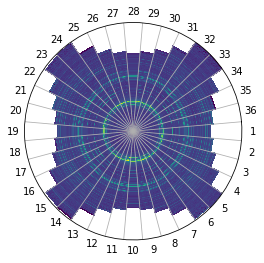

In [5]:
spectral_data.plot_polar()

The diffraction pattern is plotted with the cake number specified next to each segment. In the example data file we have used there are 36 cakes. The number of cakes is dependent on the input dataset (which is affected by how the user captured the data). The number of cakes in your dataset is determined automatically from the number of columns in the input dataset. The plot_polar command automatically adjusts to show the correct number of cakes and cake numbers according to the data file and first cake angle specified.


In order to plot a spectrum of intensity against $2\theta$ at a particular azimuthal angle, use the `plot` method of a `FitSpectrum` object, specifying which cake to plot.

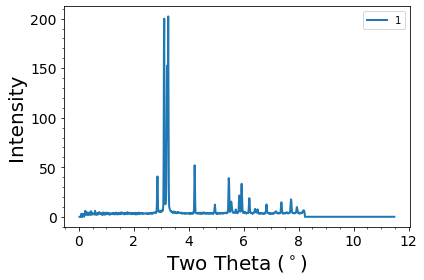

In [6]:
spectral_data.plot(1)

If you are using the interactive matplotlib backend then it should be possible to zoom and pan the graph directly.
If you are using a non-interactive backend then you can specify the x-axis limits by passing these as a Tuple to the `plot` 
method. To show the raw data points, use the *show_points* parameter.

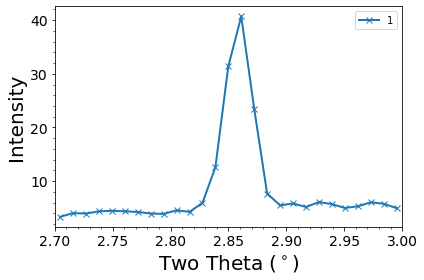

In [7]:
spectral_data.plot(1, x_range=(2.7, 3), show_points=True)

## 1.2 Fitting a single peak from a single cake

First we consider fitting a **spectrum** from a single cake. We will cover combining data from multiple cakes later.

To begin a fit, we need to define the **peak bounds** and the **maxima name**. The **peak bounds** specify where the peak is in the spectrum and the **maxima name** is a unique identifier used to refer to the maxima being fitted. All of the data between the upper and lower peak bound is used in the fit. We provide this data by initialising a `PeakParams` object. Generally speaking, is a good idea to include at least a few data points either side of the peak so the fit can find the baseline. 

Lets begin by fitting the above peak in the range 2.75 to 2.95.

In [8]:
peak_params = PeakParams((2.75, 2.95), '(10-10)')

Because the peak is only a singlet peak we do not need to provide any additional parameters other than the **peak bounds**. The fitting is able to automatically fit the maximum in a singlet peak without much help.

Now we have specified where the peak is, the method `fit_peaks` does the fitting. We use the peak params we specified above and the number of the cake we want to fit (in this case cake 1) as parameters.

In [9]:
spectral_data.fit_peaks(peak_params, 1)

Fitting complete.


The results of the fit are stored in a `PeakFit` object which is stored in `FitSpectrum` object (this instance of FitSpectrum is called *spectral_data*). The Fit parameters can be viewed by using the values parameter of the `PeakFit` object.

In [10]:
spectral_data.fitted_peaks[0].result.values

{'maximum_1_amplitude': 1.0511617853637314,
 'maximum_1_center': 2.858862226937105,
 'maximum_1_sigma': 0.013377627669297164,
 'maximum_1_fraction': 0.024507631153107112,
 'maximum_1_fwhm': 0.02675525533859433,
 'maximum_1_height': 36.617087969202494,
 'maximum_1_snr': 7.626662728311839,
 'background': 4.801194083654947}

Note that internally in lmfit, the parameters are labelled using the syntax, `maximum_X_Y` where `X` is the numerical index of the peak and `Y` is the paramter type.

To get a peak by name we can use the `get_fit` method of the `FitSpectrum` object.

In [11]:
spectral_data.get_fit("(10-10)")

This returns a `PeakFit` object. This object has a number of useful methods.

`PeakFit.result` is an lmfit `ModelResult` object. This gives detailed results of the fit - further documentation can be found at: https://lmfit.github.io/lmfit-py/model.html#the-modelresult-class

In [12]:
spectral_data.get_fit("(10-10)").result

To get at the parameters of the fit we can use `ModelResult.values`

In [13]:
spectral_data.get_fit("(10-10)").result.values

{'maximum_1_amplitude': 1.0511617853637314,
 'maximum_1_center': 2.858862226937105,
 'maximum_1_sigma': 0.013377627669297164,
 'maximum_1_fraction': 0.024507631153107112,
 'maximum_1_fwhm': 0.02675525533859433,
 'maximum_1_height': 36.617087969202494,
 'maximum_1_snr': 7.626662728311839,
 'background': 4.801194083654947}

*values* is just a python dictionary so can be subscripted to get a particular parameter.

In [14]:
spectral_data.get_fit("(10-10)").result.values['maximum_1_center']

2.858862226937105

If we want a plot of the fit the `PeakFit` object has a `plot` method:

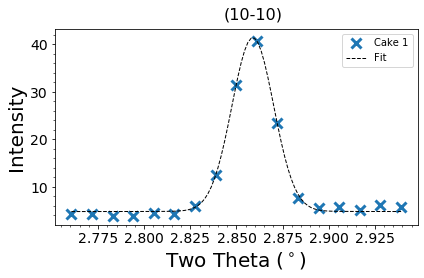

In [15]:
spectral_data.get_fit("(10-10)").plot()

## <font color='red'>Notes on Choosing Peak Bounds for single peaks</font>
The peak bounds you choose to select a peak are used to tell the fitting code the data range to fit over. The peak bounds are also used to set the initial values of the parameters for the fit. For optimal fitting speed, try to set the peak bounds such that the range of the peak bounds is approximately 8 times the full width at half maximum (FWHM) of the peak bounds. Don't worry about this too much, since the fit result should not be sensitive to small changes in peak bounds and the fit will work if the peak bounds are set between 3 to 20 times the FWHM.

In this case the FWHM for this peak is 0.025 which means that peak bounds with range between 0.075 and 0.5 should work. 

Fitting complete.


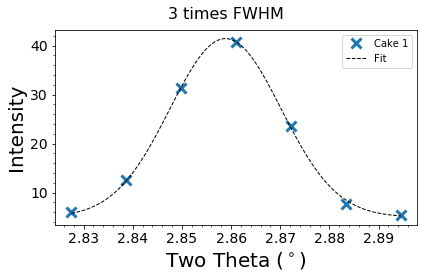

Fitting complete.


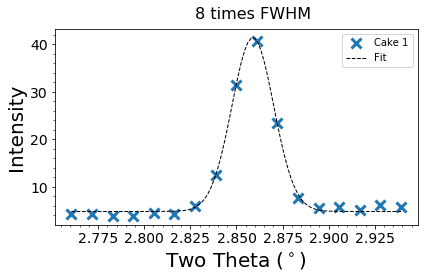

Fitting complete.


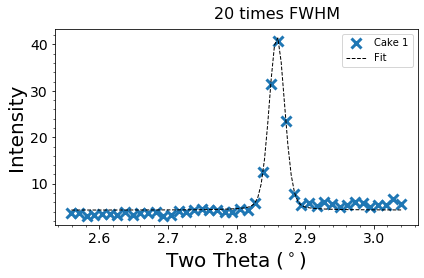

In [16]:
spectral_data.fit_peaks(PeakParams((2.82, 2.90), '3 times FWHM'), 1)
spectral_data.get_fit("3 times FWHM").plot()
spectral_data.fit_peaks(PeakParams((2.75, 2.95), '8 times FWHM'), 1)
spectral_data.get_fit("8 times FWHM").plot()
spectral_data.fit_peaks(PeakParams((2.55, 3.05), '20 times FWHM'), 1)
spectral_data.get_fit("20 times FWHM").plot()

## 1.3 Fitting multiple peaks simultaneously

It can be more convenient to specify multiple peaks and fit them all at once. Here we try to fit the first 4 peaks in the spectrum at once. First we get a good zoomed in view to see where the peaks are. As before, the arguments here are *cake_number* and *x_range*.

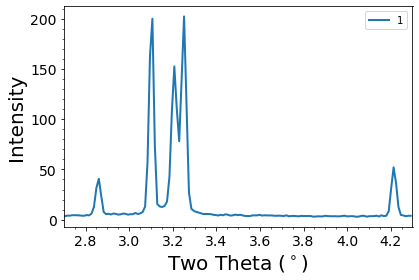

In [17]:
spectral_data.plot(1, (2.7, 4.3))

By providing a list of `PeakParams`, we can fit multiple peaks simultaneously. Once we start specifying more than one set of peak params it can be a little confusing to set the peak bounds. To make sure that we have set the peak params correctly we can use the `plot_peak_params` method of the `FitSpectrum` object to summarise the PeakParams we have set. As with any plotting function in `xrdfit`, we can use the *show_points* parameter to see the raw data points.

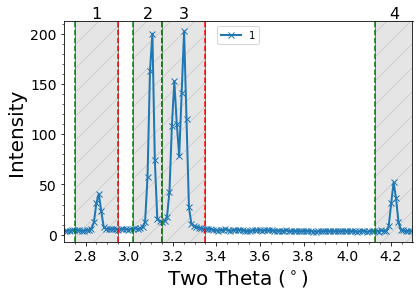

In [18]:
peak_params = [PeakParams((2.75, 2.95), '1'),
               PeakParams((3.02, 3.15), '2'),
               PeakParams((3.15, 3.35), '3'),
               PeakParams((4.13, 4.30), '4')]
spectral_data.plot_peak_params(peak_params, 1, x_range=(2.7, 4.3), show_points=True)

The grey hashed region indicates the peak bounds of the `PeakParam`. The green dashed line indicates the start of the peak bounds and the red dashed line indicates the end of the peak bounds. The code is looking for a peak in this area. The name of the peak as specified in the PeakParams is shown above each shaded area.

Now we have specified the `PeakParams`, they are passed to the `fit_peaks` method as before to do the fitting.

Each fitted peak is stored as a `PeakFit` object in the `FitExperiment`. To plot the fits to multiple peaks we iterate over the list of `PeakFit`s, calling the plot method of each.

Fitting complete.
[<xrdfit.spectrum_fitting.PeakFit object at 0x0000017616EB5278>, <xrdfit.spectrum_fitting.PeakFit object at 0x0000017616DAD6A0>, <xrdfit.spectrum_fitting.PeakFit object at 0x0000017616D70940>, <xrdfit.spectrum_fitting.PeakFit object at 0x0000017616F6F198>]


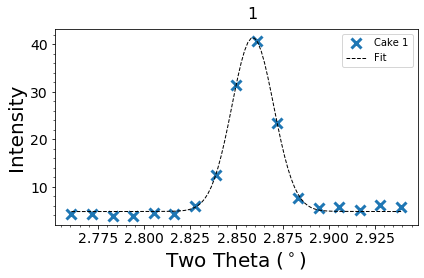

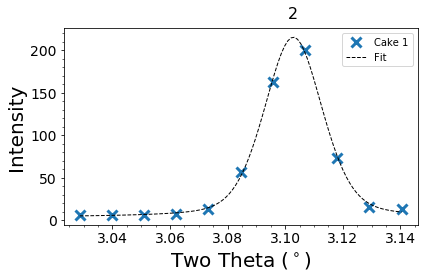

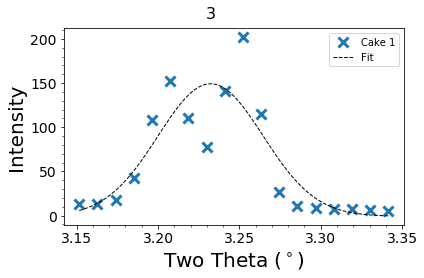

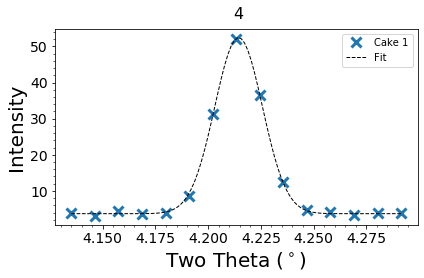

In [19]:
spectral_data.fit_peaks(peak_params, 1)

print(spectral_data.fitted_peaks)

for fit in spectral_data.fitted_peaks:
    fit.plot()

You may notice that the third peak is fitted poorly since it is really two peaks close together. It would not be possible to fit the two peaks separately as two singlet peaks since they are too close together. We call cases like these **multiplet** peaks, a single peak with multiple **maxima**. In order to fit multiplet peaks we must provide the fitting with a little more information.

## 1.4 Fitting peaks with multiple maxima

First lets zoom in to get a better view of the doublet peak

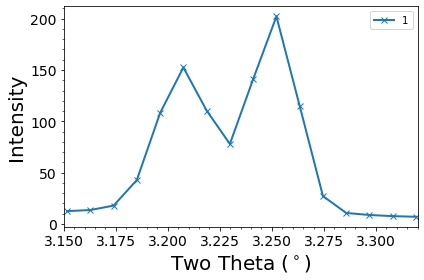

In [20]:
spectral_data.plot(1, (3.15, 3.32), show_points=True)

In order to tell the fitting algorithm to fit two **maxima** in a single peak we need to specify where one peak starts and the other ends. This means providing the `PeakParams` object with information about the position of the maximum for each peak - the **maxima bounds**.

We need to provide a min and max bound for each peak. The min and max values bound a small region where the peak maximum can be found. While we want the **peak bounds** to be reasonably wide in order to include some baseline points, the **maxima bounds** can be specified quite tightly since they are just used to distinguish the maxima centers within the peak.

The **maxima bounds** must be provided as a list of Tuples, one for each maxima in the peak. Each tuple consists of a max and min bound. The maxima bounds should be provided from left to right.

In addition, we must also provide one name for each maxima. Previously it was possible to provide a single string for a single maxima. In the case of a peak with more than one maxima the **maxima names** must be provided as a list of strings.

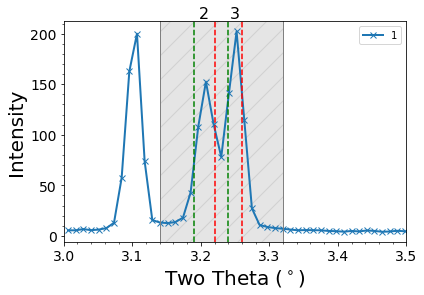

In [21]:
maxima_bounds = [(3.19, 3.22), (3.24, 3.26)]

peak_params = PeakParams((3.14, 3.32), ['2', '3'], maxima_bounds)

spectral_data.plot_peak_params(peak_params, 1, (3.0, 3.5), show_points=True)

Here we have plotted the *peak_params* provided for the double peak. As before, the grey shaded area shows the **peak bounds** but this time we can see that the green and red dashed lines show the **maxima bounds**.

In the single peak example in section 1.3 above, the green and red lines were coincident with the edges of the shaded region. This is because for a singlet peak the **maxima bounds** are set to the **peak bounds** by default.

We can now do the fit as before using the `fit_peaks` method.

To plot a multiplet peak you can specify the name of either of the maxima - in this case ``spectral_data.get_fit('2').plot()`` and ``spectral_data.get_fit('3').plot()`` would plot the same graph.

Fitting complete.


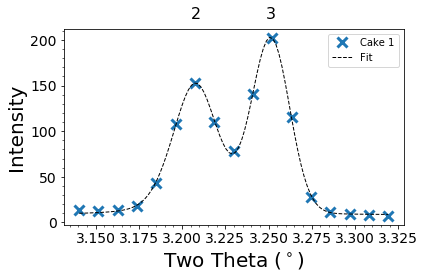

In [22]:
spectral_data.fit_peaks(peak_params, 1)
spectral_data.get_fit('2 3').plot()

Once you have set the `PeakParams`, it may be useful to print them out if you want to check exactly what peak params have been set or to output them as part of some sort of report. Printing the `PeakParams` object gives the string representation used to create it.

In [23]:
print(peak_params)

PeakParams((3.14, 3.32), '['2', '3']', [(3.19, 3.22), (3.24, 3.26)])


## <font color='red'>Notes on Choosing Maxima Bounds for multiplet peaks</font>

While we can be fairly imprecise when specifying the peak bounds, the maxima bounds must be specified a little more carefully. You should make sure that the highest data point in the maximum is captured between the min and max bounds and ideally the maxima bounds should be specified at the FWHM of the peak.

The maxima bounds are used to determine the starting parameters for the fitting function and so setting them well can significantly affect the quality of the fit and the fitting speed.

Here we show the effects of setting the maxima bounds in different places:

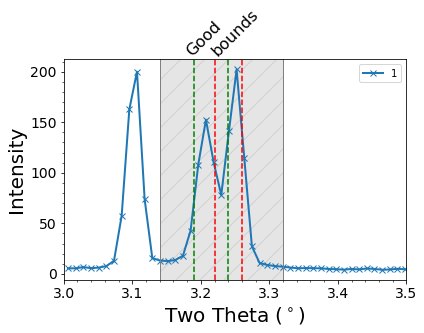

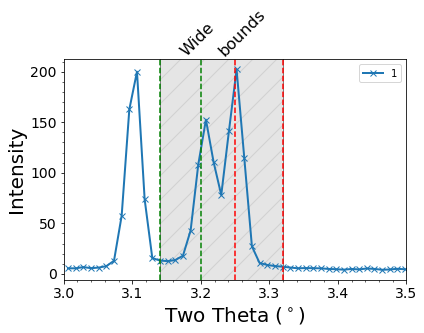

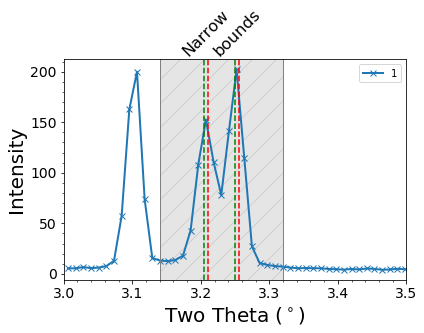

Fitting complete.


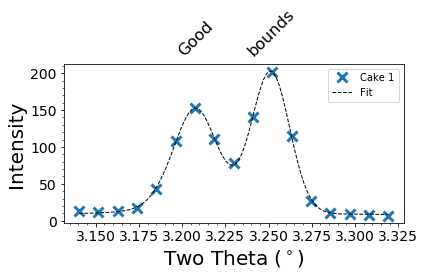

Fitting complete.


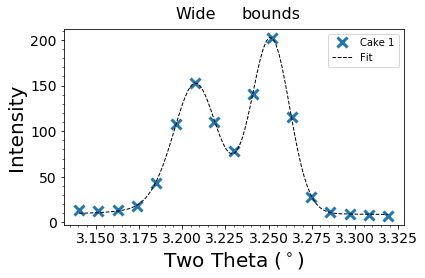

Fitting complete.


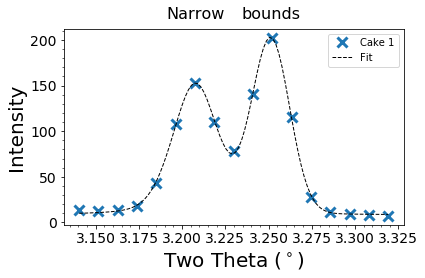

Good bounds fit took 0.056330 Seconds
Wide bounds fit took 0.119966 Seconds
Narrow bounds fit took 0.145236 Seconds


In [24]:
peak_params_1 = PeakParams((3.14, 3.32), ["Good", "bounds"], [(3.19, 3.22), (3.24, 3.26)])
peak_params_2 = PeakParams((3.14, 3.32), ["Wide", "bounds"],[(3.14, 3.25), (3.2, 3.32)])
peak_params_3 = PeakParams((3.14, 3.32), ["Narrow", "bounds"], [(3.205, 3.21), (3.25, 3.255)])

spectral_data.plot_peak_params(peak_params_1, 1, (3.0, 3.5), show_points=True, label_angle=45)
spectral_data.plot_peak_params(peak_params_2, 1, (3.0, 3.5), show_points=True, label_angle=45)
spectral_data.plot_peak_params(peak_params_3, 1, (3.0, 3.5), show_points=True, label_angle=45)

import time

# Time the good bounds fit
start_1 = time.perf_counter()
spectral_data.fit_peaks(peak_params_1, 1)
stop_1 = time.perf_counter()
spectral_data.get_fit("Good").plot(label_angle=45)

# Time the wide bounds fit
start_2 = time.perf_counter()
spectral_data.fit_peaks(peak_params_2, 1)
stop_2 = time.perf_counter()
spectral_data.get_fit("Wide").plot()

# Time the narrow bounds fit
start_3 = time.perf_counter()
spectral_data.fit_peaks(peak_params_3, 1)
stop_3 = time.perf_counter()
spectral_data.get_fit("Narrow").plot()


print(f"Good bounds fit took {stop_1 - start_1:05f} Seconds")
print(f"Wide bounds fit took {stop_2 - start_2:05f} Seconds")
print(f"Narrow bounds fit took {stop_3 - start_3:05f} Seconds")

In this case the fit has converged well for all three sets of maxima bounds although the good bounds converge two or three times as fast.

While double the speed might not seem that significant, the difference can be much greater when fitting higher number of maxima (triplets, quartets etc.) or if the maxima are less distinct. If you are fitting many peaks over hundreds or thousands of data sets this can make a big difference.

Ultimately if the maxima bounds are too far from optimal then the fitting may not converge at all and the fits will not be useful.

Also note the `label_angle` parameter to `plot_peak_params` and `FitResult.plot`, this can be provided to any fit plot to rotate the angle of the maxima labels. This can be useful if maxima are close together and this causes the labels to overlap.

## 1.5. Putting it all together

To fit the single and doublet peaks at the same time we can combine `PeakParams` seamlessly as before. Going back to the above example, we can fit the first 4 peaks in the spectrum like this:

Fitting complete.


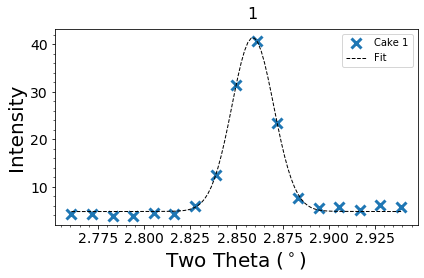

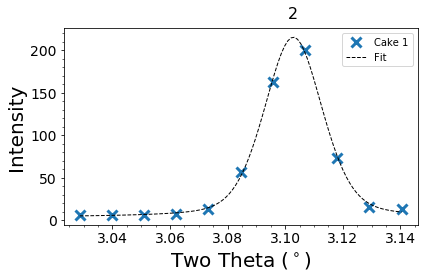

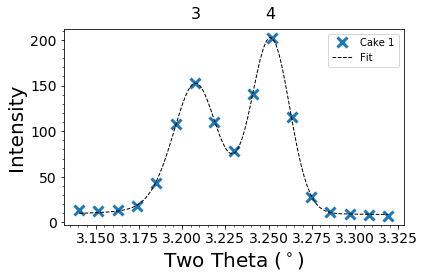

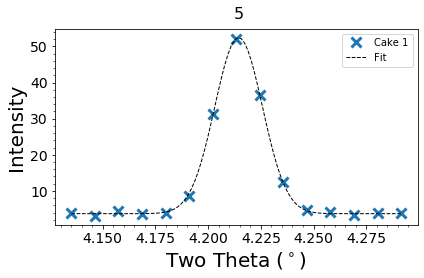

In [25]:
peak_params = [PeakParams((2.75, 2.95), '1'),
               PeakParams((3.02, 3.15), '2'),
               PeakParams((3.14, 3.32), ['3', '4'], [(3.19, 3.22), (3.24, 3.26)]),
               PeakParams((4.13, 4.30), '5')]

spectral_data.fit_peaks(peak_params, 1)

for fit in spectral_data.fitted_peaks:
    fit.plot()

This now fits all of the peaks appropriately.

However, peaks 2 and 3 are quite close - they don't have the many baseline points between them. In this case they have fitted OK, but if the fit was having trouble it would also be valid to combine the peaks as a triplet peak.

Fitting complete.


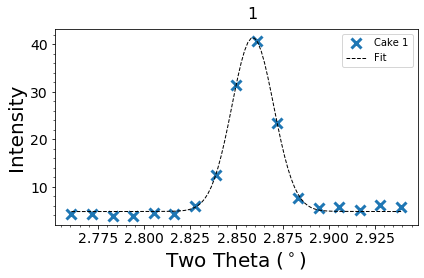

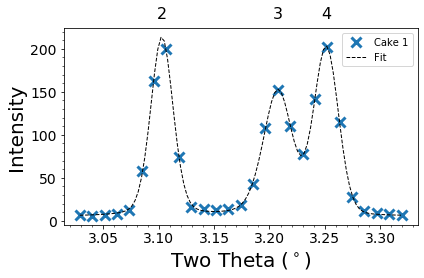

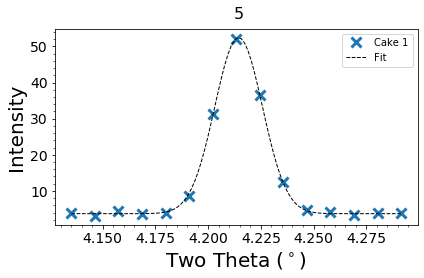

In [26]:
peak_params = [PeakParams((2.75, 2.95), '1'),
               PeakParams((3.02, 3.32), ['2', '3', '4'], [(3.09, 3.12), (3.19, 3.22), (3.24, 3.26)]),
               PeakParams((4.13, 4.30), '5')]

spectral_data.fit_peaks(peak_params, 1)

for fit in spectral_data.fitted_peaks:
    fit.plot()